In [15]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/home/jmdeloui/STL_dev/STL_main")

from STL2DKernel import STL2DKernel as STLDataClass
from STLHealpixKernel import STLHealpixKernel as STLH
from ST_Operator import ST_Operator as SO


In [41]:

target=np.random.randn(1,1,128,128)
DC=STLDataClass(target)
st_op=SO(DC)
r=st_op.apply(DC).to_flatten()

In [70]:
import torch
from torch import nn
from torch.optim import LBFGS

# Suppose:
# - STLDataClass is your data wrapper class (e.g. STL2DKernel)
# - st_op is an operator such that st_op.apply(DC).to_flatten()
#   returns a 1D tensor of scattering coefficients.
# - target is your reference map of shape (1,1,128,128)
#   and r is the corresponding scattering vector.


class ScatteringMatchModel(nn.Module):
    """
    Model that holds a learnable signal u and
    computes its scattering statistics via st_op.
    """
    def __init__(self, st_op, STLDataClass, init_shape, device=None, dtype=None):
        super().__init__()
        self.st_op = st_op           # scattering operator (already built)
        self.STLDataClass = STLDataClass  # data wrapper class

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if dtype is None:
            dtype = torch.float32

        # Initialize u as a learnable parameter
        # You can also initialize from target if you prefer
        self.u = nn.Parameter(torch.randn(init_shape, device=device, dtype=dtype))

    def forward(self):
        """
        Forward pass: compute scattering coefficients of u
        and return them as a flattened 1D tensor.
        """
        # Wrap u in your STL data class
        DC_u = self.STLDataClass(self.u)

        # Apply scattering operator
        st_u = self.st_op.apply(DC_u)

        # Flatten the scattering statistics
        # (adapt this if your method is named differently)
        s_flat_u = st_u.to_flatten()

        return s_flat_u


def optimize_scattering_LBFGS(target, STLDataClass, SO_class,
                              max_iter=200, lr=1.0, history_size=50):
    """
    Run LBFGS optimization to find u such that its scattering
    coefficients match those of `target`.

    Parameters
    ----------
    target : torch.Tensor or np.ndarray
        Reference data of shape (1, 1, Nx, Ny).
    STLDataClass : class
        Your data wrapper class (e.g. STL2DKernel).
    SO_class : class or callable
        Scattering operator constructor, called like SO_class(DC_target).
    max_iter : int
        Maximum number of LBFGS outer iterations.
    lr : float
        Learning rate for LBFGS.
    history_size : int
        LBFGS history size.

    Returns
    -------
    u_opt : torch.Tensor
        Optimized signal of shape (1,1,Nx,Ny).
    """

    # Ensure target is a torch tensor on some device/dtype
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    target = torch.as_tensor(target, device=device, dtype=torch.float32)

    # Build STLDataClass for target
    DC_target = STLDataClass(target)

    # Build scattering operator based on target geometry
    st_op = SO_class(DC_target)

    # Compute target scattering vector r (no grad needed)
    with torch.no_grad():
        r = st_op.apply(DC_target).to_flatten()
    r = r.detach()  # make sure it does not require gradients

    # Initialize model with a learnable u
    model = ScatteringMatchModel(
        st_op=st_op,
        STLDataClass=STLDataClass,
        init_shape=target.shape,
        device=device,
        dtype=target.dtype,
    )

    # LBFGS optimizer on model.u
    optimizer = LBFGS(
        [model.u],
        lr=lr,
        max_iter=max_iter,
        history_size=history_size,
        line_search_fn="strong_wolfe"
    )

    # LBFGS requires a closure that recomputes the loss and gradients
    def closure():
        optimizer.zero_grad()

        # Scattering coefficients of current u
        s_flat_u = model()

        # Quadratic loss between target and current scattering coefficients
        loss = ((s_flat_u - r).abs()).sum()

        loss.backward()
        return loss

    # Run LBFGS optimization
    loss = optimizer.step(closure)

    print(loss)
    # Extract optimized u
    u_opt = model.u.detach()

    return u_opt

In [77]:
import requests

url = "https://github.com/jmdelouis/FOSCAT/raw/main/src/tests/cloud_fields.npy"  # Lien brut
filename = "cloud_fields.npy"  # Nom du fichier local

# Télécharger le fichier
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"Fichier téléchargé : {filename}")
else:
    print(f"Échec du téléchargement, code HTTP : {response.status_code}")

image_target=np.load('cloud_fields.npy')[1

plt.imshow(image_target,origin='lower')

SyntaxError: '[' was never closed (3277520607.py, line 15)

In [74]:
%%time
target = np.log(image_target[None,None,:,:]+0.6)

u_opt = optimize_scattering_LBFGS(
    target=target,
    STLDataClass=STLDataClass,   # ta classe (ex: STL2DKernel)
    SO_class=SO,                 # ton opérateur de scattering
    max_iter=200,
    lr=1
)

tensor(2.5648, grad_fn=<SumBackward0>)
CPU times: user 11.7 s, sys: 163 ms, total: 11.8 s
Wall time: 10.8 s


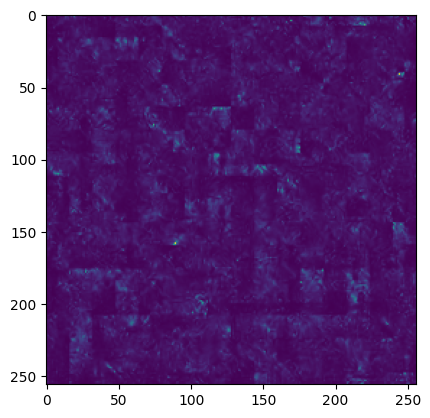

In [75]:
plt.imshow(np.exp(u_opt[0,0].cpu().numpy()-0.6))

Exception: Scattering operator and data should have same N0

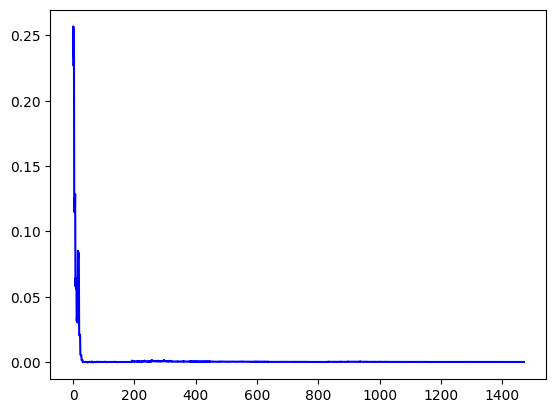

In [20]:
plt.plot(r.cpu().numpy(),color='b')
r_u=st_op.apply(STLDataClass(u_opt)).to_flatten()
plt.plot(r_u.to_flatten().cpu().numpy(),color='r')
plt.xscale('log')
plt.yscale('log')

In [2]:
DC=STLH(np.random.randn(10,1,12*32**2),nside=32)
st_op=SO(DC)

r=st_op.apply(DC)

AttributeError: 'STLHealpixKernel' object has no attribute 'nside0'

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.plot(r.S1[0,0].cpu().numpy().flatten())
plt.subplot(2,2,2)
plt.plot(r.S2[0,0].cpu().numpy().flatten())
plt.subplot(2,2,3)
plt.plot(r.S3[0,0].cpu().numpy().flatten())
plt.subplot(2,2,4)
plt.plot(r.S4[0,0].cpu().numpy().flatten())

In [ ]:
wop=DC.get_wavelet_op()
w=wop.kernel[0]

In [ ]:
import matplotlib.pyplot as plt

for i in range(4):
    print(np.mean(w[i].cpu().numpy().real),np.mean(w[i].cpu().numpy().imag),np.sum(abs(w[i].cpu().numpy())))
    plt.subplot(3,4,1+i)
    plt.imshow(w[i].cpu().numpy().real)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,5+i)
    plt.imshow(w[i].cpu().numpy().imag)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,9+i)
    plt.imshow(abs(w[i].cpu().numpy()))
    plt.xticks([])
    plt.yticks([])

In [ ]:
r=wop.apply(DC,0).array

In [ ]:
for i in range(4):
    print(np.mean(w[i].cpu().numpy().real),np.mean(w[i].cpu().numpy().imag),np.sum(abs(w[i].cpu().numpy())))
    plt.subplot(3,4,1+i)
    plt.imshow(r[i].cpu().numpy().real)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,5+i)
    plt.imshow(r[i].cpu().numpy().imag)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,9+i)
    plt.imshow(abs(r[i].cpu().numpy()))
    plt.xticks([])
    plt.yticks([])

In [ ]:
LDC=DC.downsample(1,copy=True)
r=wop.apply(LDC,1).array
amp=1
for i in range(4):
    print(np.mean(w[i].cpu().numpy().real),np.mean(w[i].cpu().numpy().imag),np.sum(abs(w[i].cpu().numpy())))
    plt.subplot(3,4,1+i)
    plt.imshow(r[i].cpu().numpy().real,vmin=-amp,vmax=amp)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,5+i)
    plt.imshow(r[i].cpu().numpy().imag,vmin=-amp,vmax=amp)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,9+i)
    plt.imshow(abs(r[i].cpu().numpy()),vmin=0,vmax=amp)
    plt.xticks([])
    plt.yticks([])

In [ ]:
LDC=STLDataClass(np.random.randn(10,512,512))

amp=0.3

plt.figure(figsize=(16,16))
for j in range(5):
    r=wop.apply(LDC,j).array[0]
    for i in range(4):
        plt.subplot(5,4,1+4*j+i)
        plt.imshow(abs(r[i].cpu().numpy()),vmin=0,vmax=amp)
    plt.xticks([])
    plt.yticks([])
    
    LDC=LDC.downsample(j+1,copy=True)
    print(LDC.array.shape)